In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR,MultiStepLR
import math
import keras
from torch.utils import data
import matplotlib.pyplot as plt
from datetime import datetime

def load_dataset(task='smnist'):
    if task == 'smnist':
        (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    # elif task == 'psmnist':
    #     X_train = np.load('./ps_data/ps_X_train.npy')
    #     X_test = np.load('./ps_data/ps_X_test.npy')
    #     y_train = np.load('./ps_data/Y_train.npy')
    #     y_test = np.load('./ps_data/Y_test.npy')
    else:
        print('only two task, -- smnist and psmnist')
        return 0
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_train = torch.from_numpy(y_train).long()
    y_test = torch.from_numpy(y_test).long()
    train_dataset = data.TensorDataset(X_train,y_train) # create train datset
    test_dataset = data.TensorDataset(X_test,y_test) # create test datset

    return train_dataset,test_dataset

'''
STEP 3a_v2: CREATE Adaptative spike MODEL CLASS
'''
b_j0 = 0.01  # neural threshold baseline
tau_m = 20  # ms membrane potential constant
R_m = 1  # membrane resistance
dt = 1  #
gamma = .5  # gradient scale
lens = 0.5

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        #temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        return grad_input * temp.float() * gamma


act_fun_adp = ActFun_adp.apply



def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=1):
    #     tau_adp = torch.FloatTensor([tau_adp])
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    ro = torch.exp(-1. * dt / tau_adp).cuda()
    # tau_adp is tau_adaptative which is learnable # add requiregredients
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b

def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    mem = mem * alpha + (1. - alpha) * R_m * inputs
    return mem


class RNN_custom(nn.Module):
    def __init__(self, input_size, stride, hidden_dims, output_size, DC_f='mem'):
        super(RNN_custom, self).__init__()

        self.DC_f = DC_f

        self.stride = stride
        self.input_size = input_size
        self.output_size = output_size
    
        self.r1_dim = hidden_dims[0]
        self.r2_dim = hidden_dims[1]
        self.d1_dim = hidden_dims[2]
        self.i2h = nn.Linear(input_size, self.r1_dim)
        self.h2h = nn.Linear(self.r1_dim, self.r1_dim)
        self.h2d = nn.Linear(self.r1_dim, self.r2_dim)
        self.d2d = nn.Linear(self.r2_dim, self.r2_dim)
        self.dense1 = nn.Linear(self.r2_dim, self.d1_dim)
        self.d2o = nn.Linear(self.d1_dim, self.output_size)

        self.tau_adp_r1 = nn.Parameter(torch.Tensor(self.r1_dim))
        self.tau_adp_r2 = nn.Parameter(torch.Tensor(self.r2_dim))
        self.tau_adp_d1 = nn.Parameter(torch.Tensor(self.d1_dim))
        self.tau_adp_o = nn.Parameter(torch.Tensor(self.output_size))

        self.tau_m_r1 = nn.Parameter(torch.Tensor(self.r1_dim))
        self.tau_m_r2 = nn.Parameter(torch.Tensor(self.r2_dim))
        self.tau_m_d1 = nn.Parameter(torch.Tensor(self.d1_dim))
        self.tau_m_o = nn.Parameter(torch.Tensor(self.output_size))
 
        nn.init.orthogonal_(self.h2h.weight)
        nn.init.xavier_uniform_(self.i2h.weight)
        nn.init.xavier_uniform_(self.h2d.weight)
        nn.init.xavier_uniform_(self.d2d.weight)
        nn.init.xavier_uniform_(self.dense1.weight)
        nn.init.xavier_uniform_(self.d2o.weight)
        
        nn.init.constant_(self.i2h.bias, 0)
        nn.init.constant_(self.h2h.bias, 0)
        nn.init.constant_(self.h2d.bias, 0)
        nn.init.constant_(self.d2d.bias, 0)
        nn.init.constant_(self.dense1.bias, 0)
        nn.init.constant_(self.d2o.bias, 0)

        nn.init.normal_(self.tau_adp_r1, 700,25)
        nn.init.normal_(self.tau_adp_r2, 700,25)
        nn.init.normal_(self.tau_adp_o, 700,25)
        nn.init.normal_(self.tau_adp_d1, 700,25)

        nn.init.normal_(self.tau_m_r1, 20,5)
        nn.init.normal_(self.tau_m_r2, 20,5)
        nn.init.normal_(self.tau_m_o, 20,5)
        nn.init.normal_(self.tau_m_d1, 20,5)

        self.b_r1 =self.b_r2 = self.b_o  = self.b_d1  = 0
    
    def compute_input_steps(self,seq_num):
        return int(seq_num/self.stride)

    def forward(self, input):
        batch_size, seq_num, input_dim = input.shape
        self.b_r1 =self.b_r2 = self.b_o  = self.b_d1  = b_j0
        
        r1_mem = r1_spike = torch.rand(batch_size, self.r1_dim).cuda()
        r2_mem = r2_spike = torch.rand(batch_size, self.r2_dim).cuda()
        d1_mem = d1_spike = torch.rand(batch_size, self.d1_dim).cuda()
        d2o_spike = output_sumspike = d2o_mem = torch.rand(batch_size, output_dim).cuda()
        
        
        input = input/255.
        input_steps  = self.compute_input_steps(seq_num)
        r1_spikes = []
        r2_spikes = []
        d1_spikes = []
        d2_spikes = []
        for i in range(input_steps):
            start_idx = i*self.stride
            if start_idx < (seq_num - self.input_size):
                input_x = input[:, start_idx:start_idx+self.input_size, :].reshape(-1,self.input_size)
            else:
                input_x = input[:, -self.input_size:, :].reshape(-1,self.input_size)
            #print(input_x.shape)
            h_input = self.i2h(input_x.float()) + self.h2h(r1_spike)
            r1_mem, r1_spike, theta_r1, self.b_r1 = mem_update_adp(h_input,r1_mem, r1_spike, self.tau_adp_r1, self.tau_m_r1,self.b_r1)

            d_input = self.h2d(r1_spike) + self.d2d(r2_spike)
            r2_mem, r2_spike, theta_r2, self.b_r2 = mem_update_adp(d_input, r2_mem, r2_spike, self.tau_adp_r2,self.tau_m_r2, self.b_r2)

            d1_mem, d1_spike, theta_d1, self.b_d1 = mem_update_adp(self.dense1(r2_spike), d1_mem, d1_spike, self.tau_adp_d1,self.tau_m_d1, self.b_d1)            

            if self.DC_f[:3]=='adp':
                d2o_mem, d2o_spike, theta_o, self.b_o = mem_update_adp(self.d2o(d1_spike),d2o_mem, d2o_spike, self.tau_adp_o, self.tau_m_o, self.b_o)
            elif self.DC_f == 'integrator':
                d2o_mem = output_Neuron(self.d2o(d1_spike),d2o_mem, self.tau_m_o)
            if i >= 0: 
                if self.DC_f == 'adp-mem':
                    output_sumspike = output_sumspike + F.softmax(d2o_mem,dim=1)
                elif self.DC_f =='adp-spike':
                    output_sumspike = output_sumspike + d2o_spike
                elif self.DC_f =='integrator':
                    output_sumspike =output_sumspike+ F.softmax(d2o_mem,dim=1)
            r1_spikes.append(r1_spike.detach().cpu().numpy())
            r2_spikes.append(r2_spike.detach().cpu().numpy())
            d1_spikes.append(d1_spike.detach().cpu().numpy())
            d2_spikes.append(d2o_spike.detach().cpu().numpy())
        return output_sumspike, [r1_spikes,r2_spikes,d1_spikes,d2_spikes]

In [8]:
def test(model, dataloader):
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in dataloader:
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.long().cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    accuracy = 100. * correct.numpy() / total
    return accuracy


In [9]:
batch_size = 200
task = 'smnist'
DC_f = 'adp-spike'

train_dataset,test_dataset = load_dataset(task)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)


input_dim = 1
input_size=8
stride = 1
hidden_dims = [64,256,256]
output_dim = 10
seq_dim = int(784 / input_dim)  # Number of steps to unroll

model = RNN_custom(input_size, stride,hidden_dims, output_dim,DC_f=DC_f)

model = torch.load('./model/model_98.21_Task-smnist||Time-30-06-2020 16:33:05||EC_f--rbf||DC_f--adp-spike||multiinput-multi_input.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
model.to(device)

device: cuda:0


RNN_custom(
  (i2h): Linear(in_features=8, out_features=64, bias=True)
  (h2h): Linear(in_features=64, out_features=64, bias=True)
  (h2d): Linear(in_features=64, out_features=256, bias=True)
  (d2d): Linear(in_features=256, out_features=256, bias=True)
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (d2o): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
accuracy = test(model,test_loader)
print('test Accuracy: ', accuracy)

test Accuracy:  98.11


In [12]:
i = 0
for images, labels in test_loader:
    if i == 0:
        i+=1   
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, states = model(images)
    else:
        break

In [13]:
r1_spike_np = np.array(states[0])
r2_spike_np = np.array(states[1])
d1_spike_np = np.array(states[2])
d2_spike_np = np.array(states[3])

In [14]:
r1_spike_np.shape,r2_spike_np.shape,d1_spike_np.shape,d2_spike_np.shape

((784, 200, 64), (784, 200, 256), (784, 200, 256))

In [16]:
b = r1_spike_np.shape[1]
spikes = np.zeros((784,b,64+256+256+10))
spikes[:,:,:64] = r1_spike_np
spikes[:,:,64:64+256]= r2_spike_np
spikes[:,:,64+256:64+256+256] = d1_spike_np
spikes[:,:,64+256+256:] = d2_spike_np

In [29]:
np.mean(r1_spike_np),np.mean(r2_spike_np),np.mean(d1_spike_np),np.mean(d2_spike_np),np.mean(spikes)

(0.119212076, 0.073217124, 0.041618925, 0.06428403132086168)

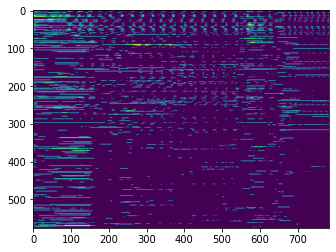

In [19]:
plt.imshow(spikes[:,1,:].T)

In [22]:
spike_count = {'total':[],'fr':[],'per step':[]}
for images, labels in test_loader: 
    images = images.view(-1, seq_dim, input_dim).to(device)
    outputs, states = model(images)

    r1_spike_np = np.array(states[0])
    r2_spike_np = np.array(states[1])
    d1_spike_np = np.array(states[2])
    d2_spike_np = np.array(states[3])
    b = r1_spike_np.shape[1]
    spikes = np.zeros((784,b,64+256+256+10))
    spikes[:,:,:64] = r1_spike_np
    spikes[:,:,64:64+256]= r2_spike_np
    spikes[:,:,64+256:64+256+256] = d1_spike_np
    spikes[:,:,64+256+256:] = d2_spike_np

    spike_count['total'].append([np.mean(np.sum(spikes,axis=(0,2))),np.max(np.sum(spikes,axis=(0,2))),np.min(np.sum(spikes,axis=(0,2)))])
    spike_count['per step'].append([np.mean(np.sum(spikes,axis=(2))),np.max(np.sum(spikes,axis=(2))),np.min(np.sum(spikes,axis=(2)))])
    spike_count['fr'].append(np.mean(spikes))

In [23]:
spike_total = np.array(spike_count['total'])
np.mean(spike_total[0]),np.max(spike_total[1]),np.min(spike_total[2])

(29013.766666666666, 31774.0, 26264.0)

In [25]:
spike_per = np.array(spike_count['per step'])
np.mean(spike_per[0]),np.max(spike_per[1]),np.min(spike_per[2])

(91.06177721088436, 239.0, 0.0)

In [26]:
spike_fr = np.array(spike_count['fr'])
np.mean(spike_fr[0])

0.06455786741780045